In [ ]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import yaml

from TRN_functions import info_get_prevstimulus, CalciumPlotter, insert_level_multiindex, stats_df, str_to_tuple, angle, calculate_reversals

/tmp/ipykernel_197567/3745621619.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## I/O

In [ ]:
config_path = "TRN_config.yml"
config = yaml.safe_load(open(config_path, "r"))

exp = config['filesettings']['experiment']
datestr = config['filesettings']['date']
mov_path = os.path.join(config['filesettings']['videopath'], exp)
inpath = os.path.join(config['filesettings']['outpath'], exp, datestr)

info = pd.read_csv(os.path.join(inpath, config['filesettings']['fileinfo']), index_col='plate')
list_movies = list(info.index)
first_mov = np.sort(list_movies)[0].replace(exp,'')
last_mov = np.sort(list_movies)[-1].replace(exp,'')

In [32]:
file_str = f'{exp}_{first_mov}-{last_mov}_mask_{datestr}'

multi_sig = pd.read_json(os.path.join(inpath, file_str+'.json'))
sig_cols = [eval(c) for c in (multi_sig.columns)]
multi_sig.columns = pd.MultiIndex.from_tuples(sig_cols)

sig_type = 'max'
fps = config['settings']['fps']

valid_range = info['valid range'].apply(str_to_tuple)
multi_sig = multi_sig.interpolate(limit=30)

### individual file analysis

LB012034


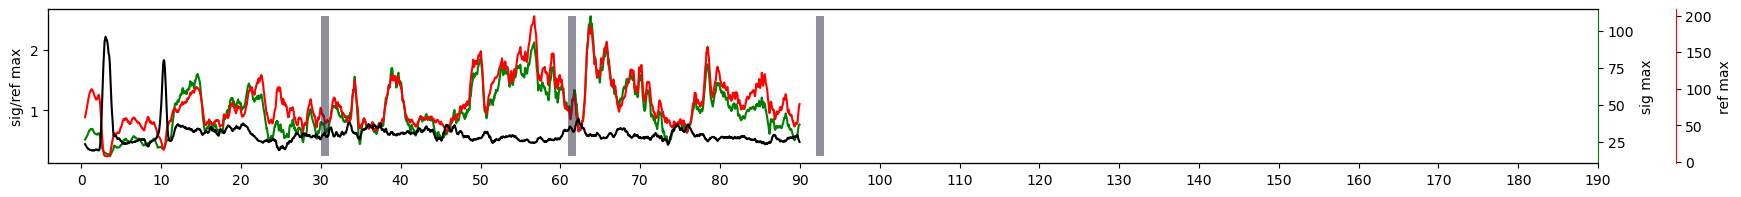

(0.2801227109732609, 1.000413502557526)


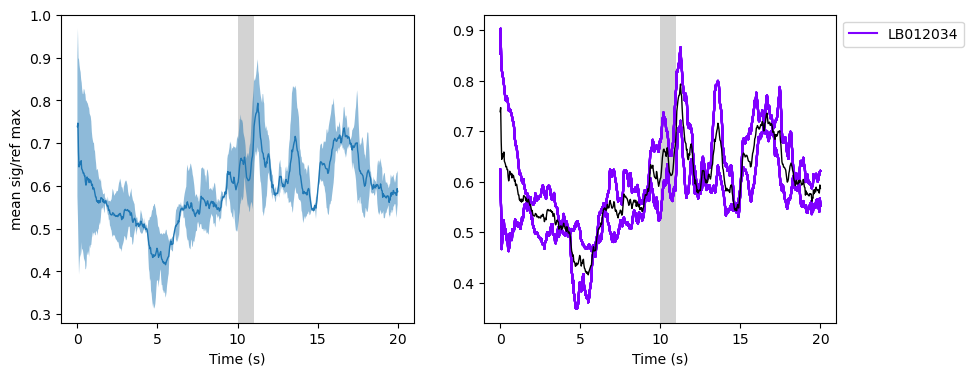

LB012035


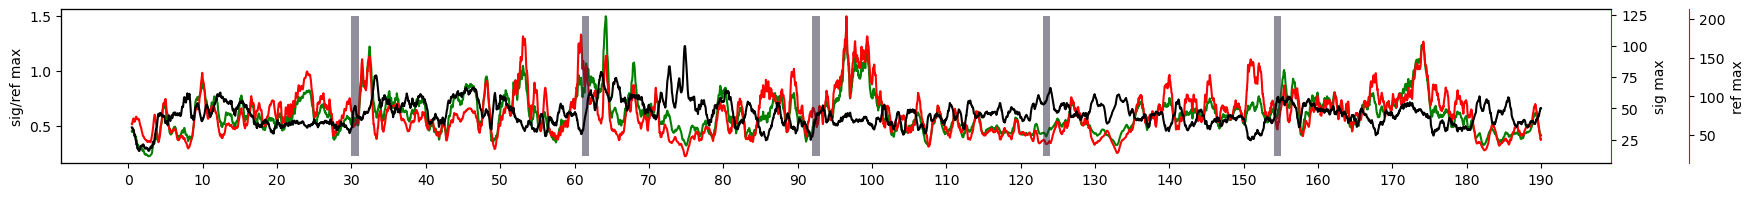

(0.3465381259593521, 0.922290225552961)


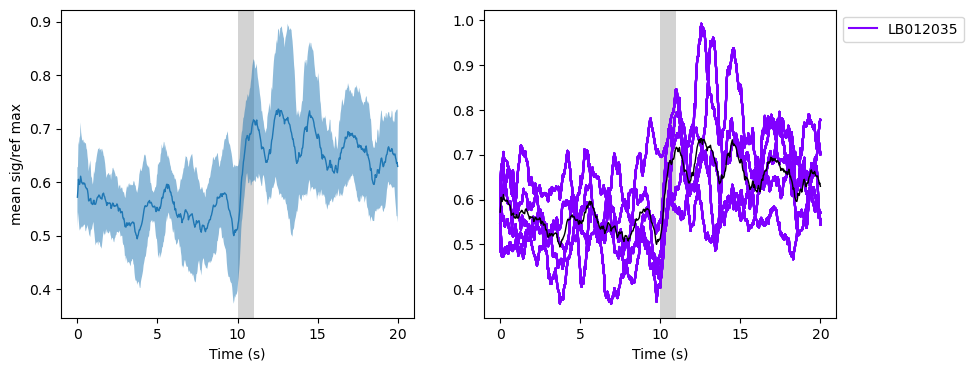

LB012036


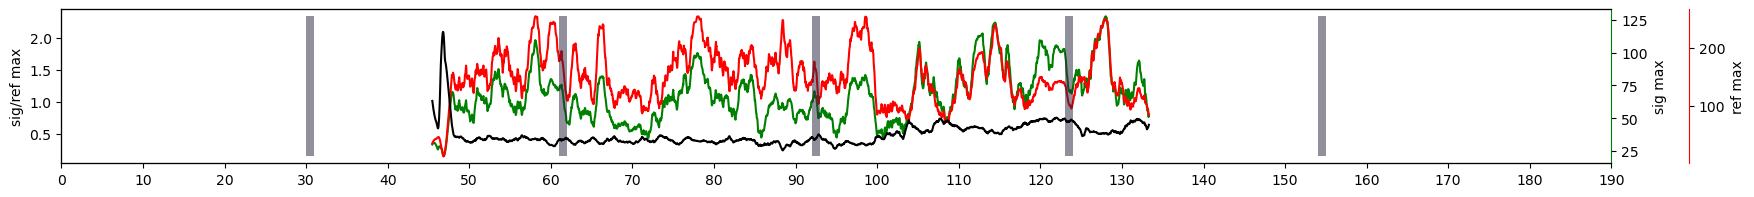

(0.26087763377383194, 0.8280470477649962)


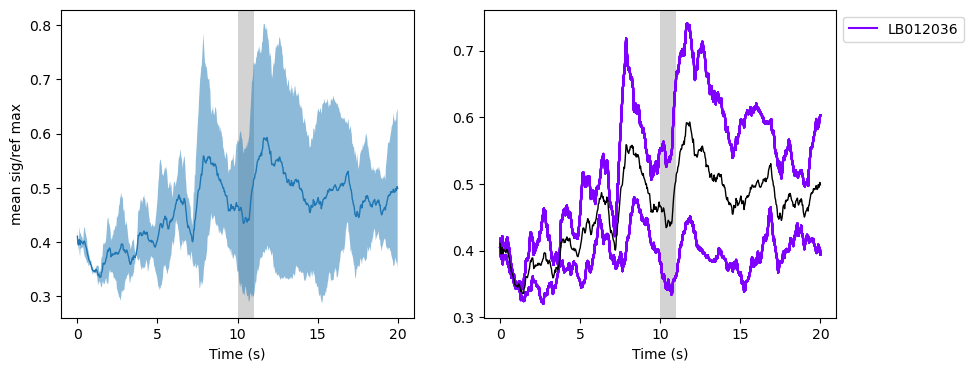

LB012037


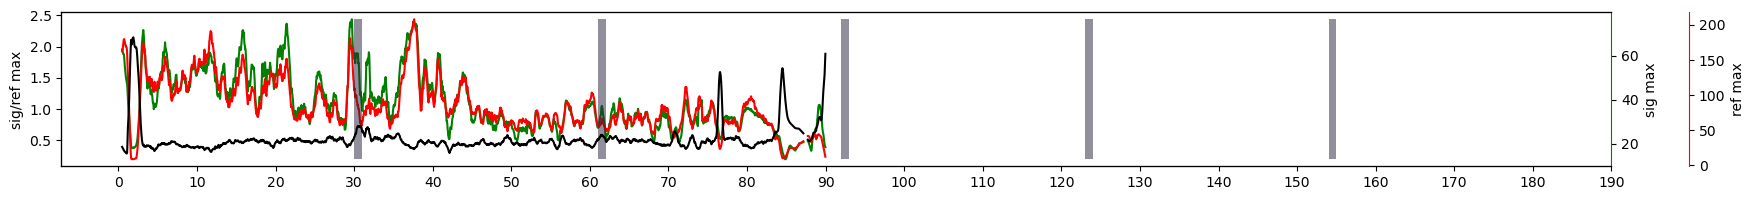

(0.26601526838228223, 0.7870859261360837)


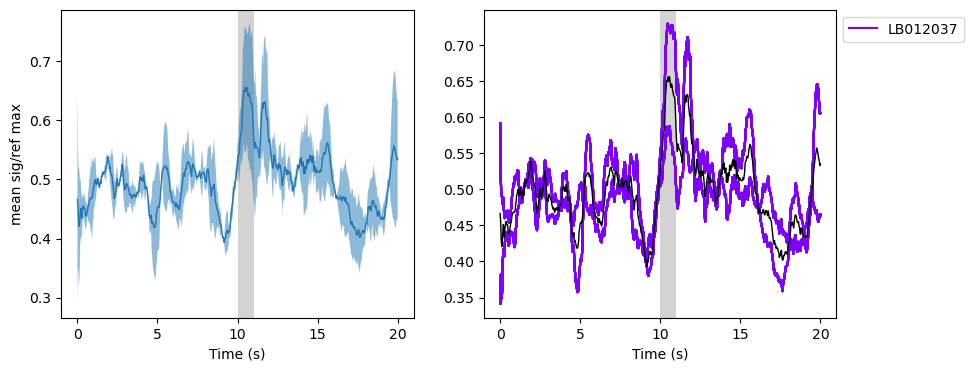

LB012038


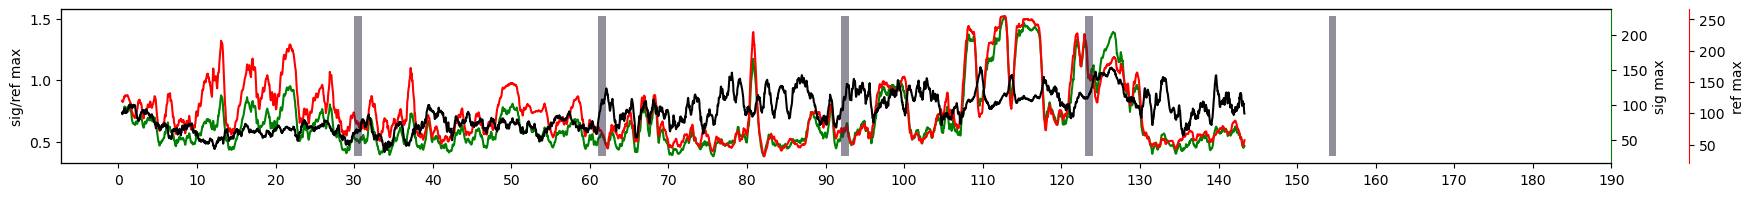

(0.4362510724123137, 1.1143272417926686)


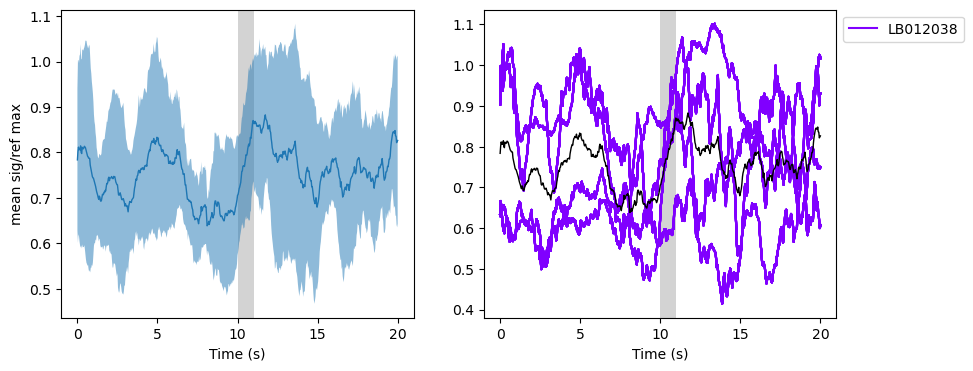

LB012039


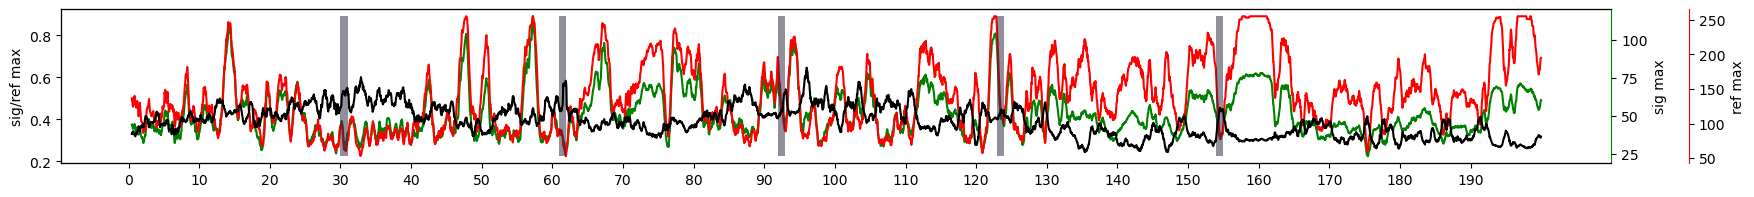

(0.2432431297638179, 0.5907080131904271)


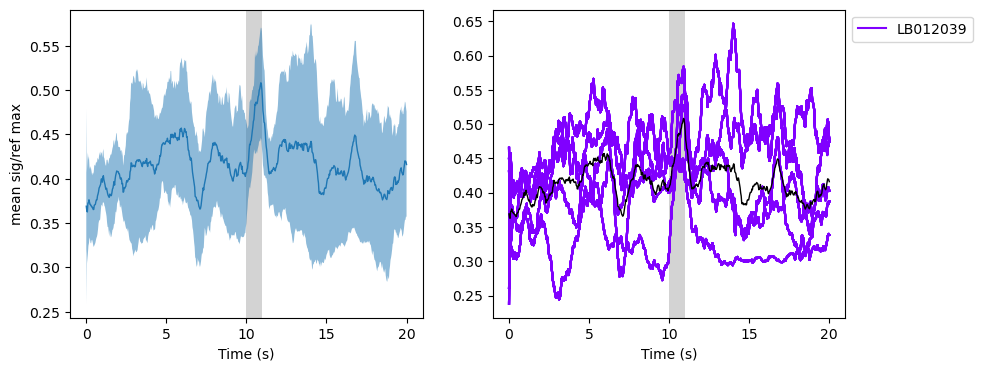

LB012040


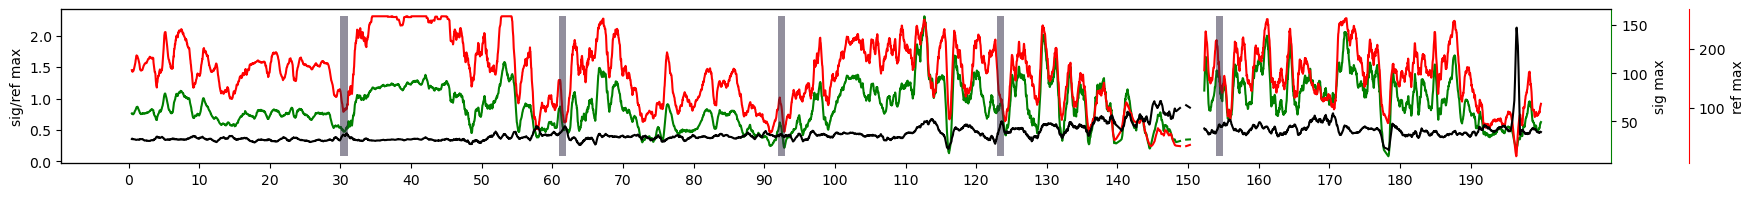

(0.1772126331882012, 0.832654987796202)


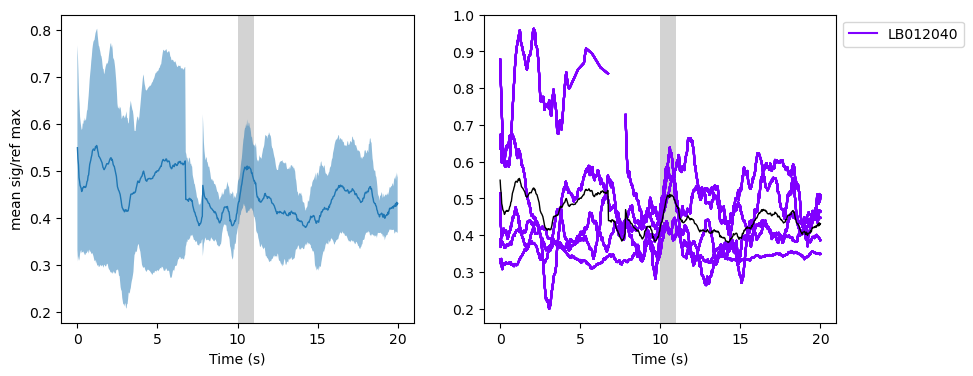

LB012041


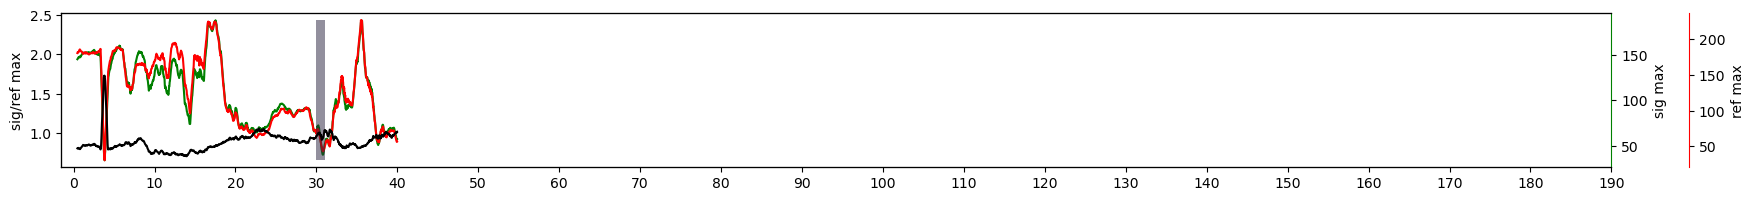

(0.794346587176, 1.0697078957573334)


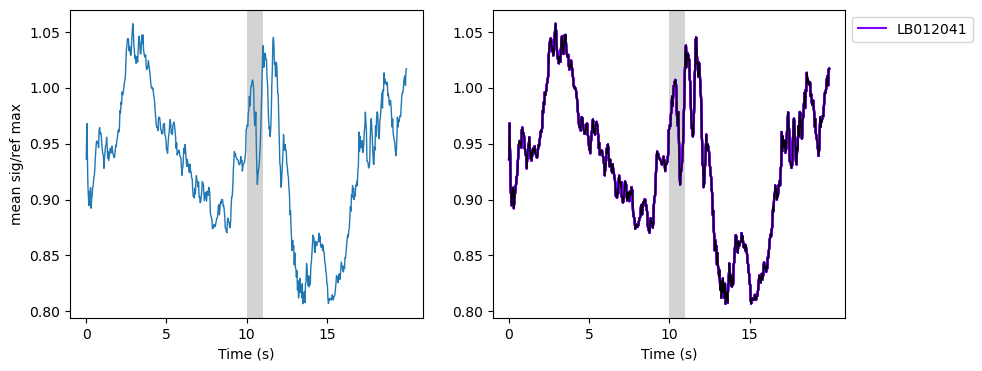

LB012042


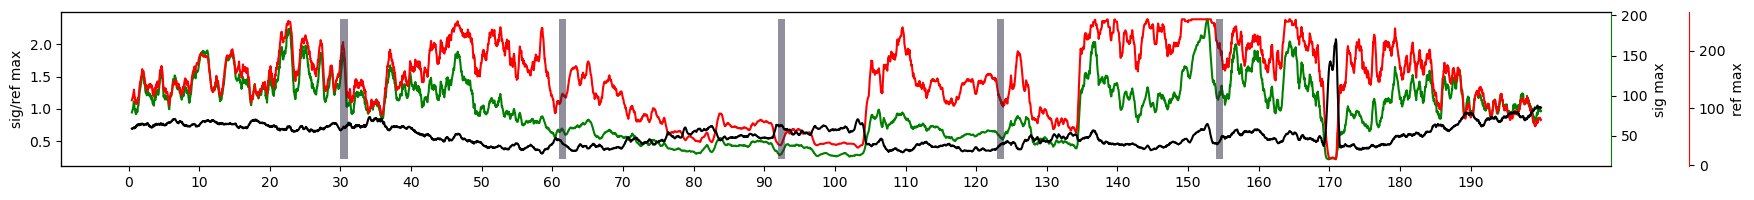

(0.3128289661388241, 0.8267801972400346)


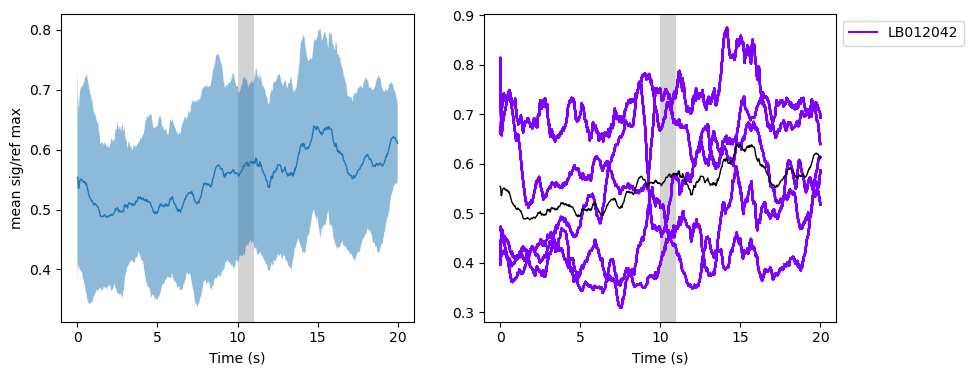

LB012043


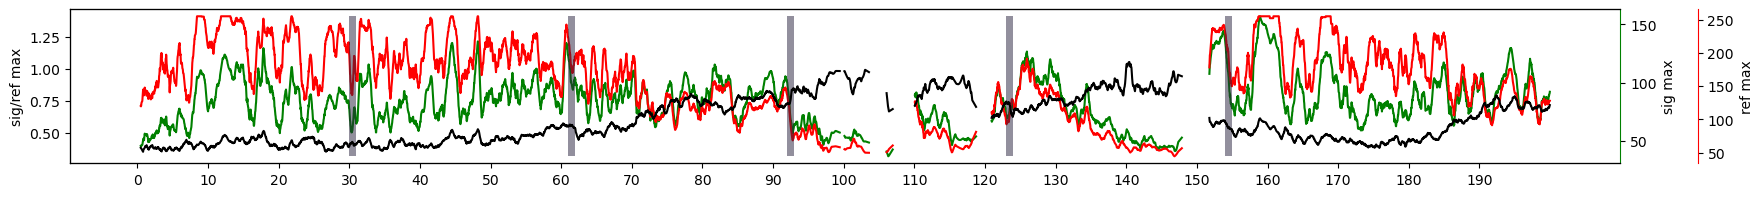

(0.3028468319587456, 0.9914947112336704)


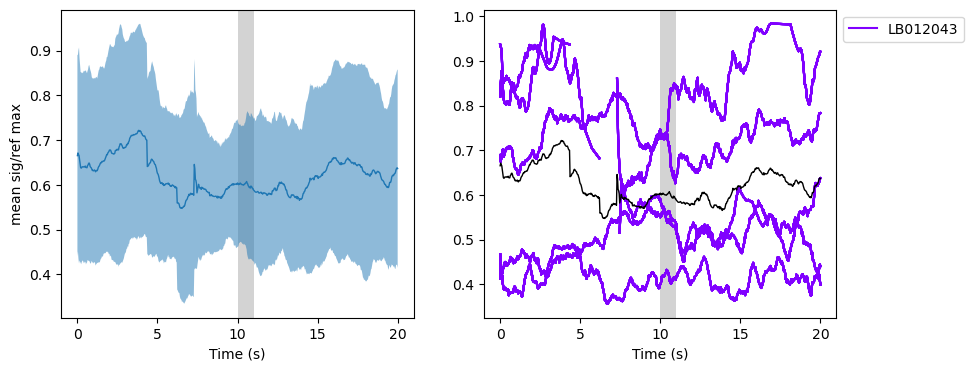

LB012044


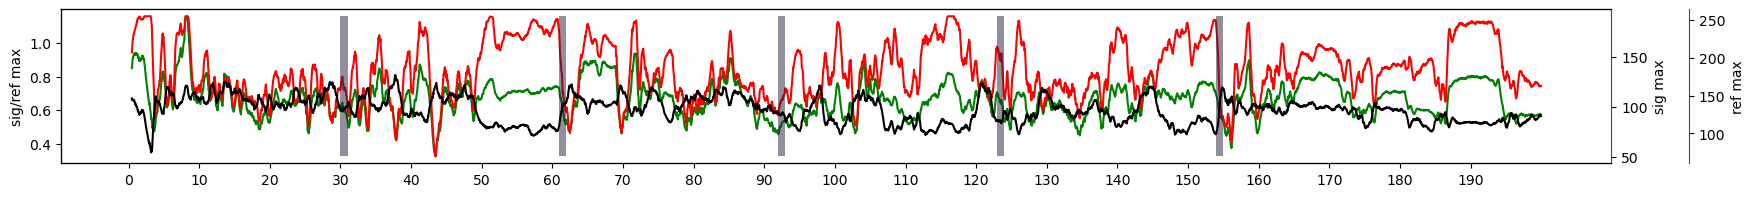

(0.4255166211830082, 0.7659982106537258)


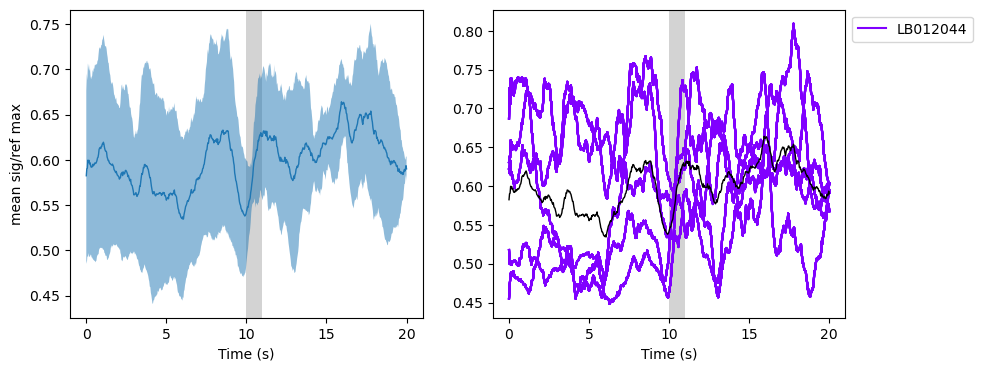

LB012045


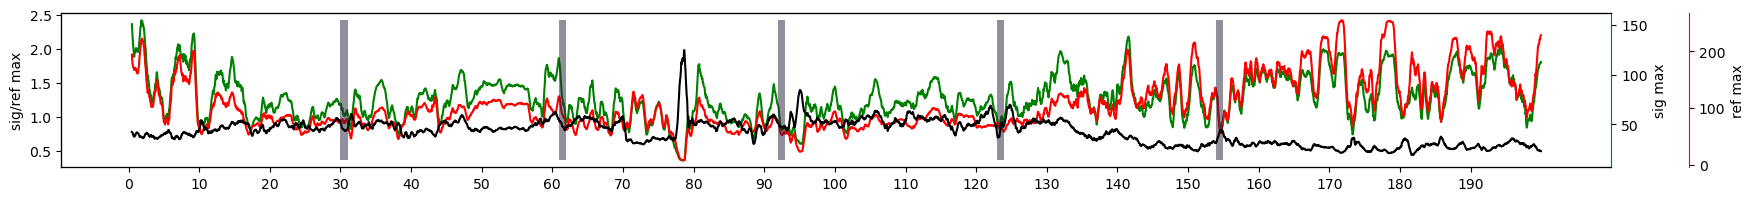

(0.5423837010421695, 1.2431427081963191)


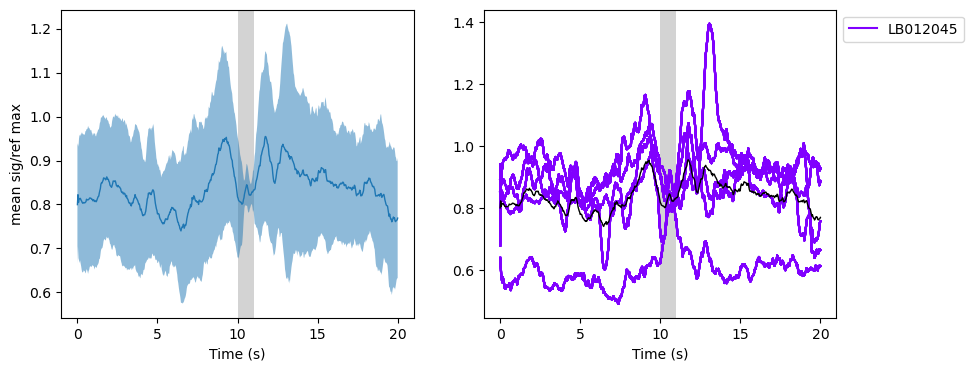

LB012046


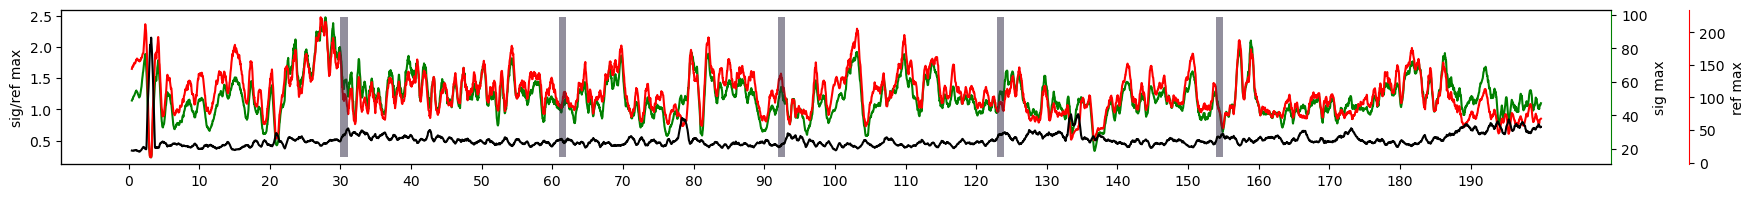

(0.361362821725118, 0.6803724499303838)


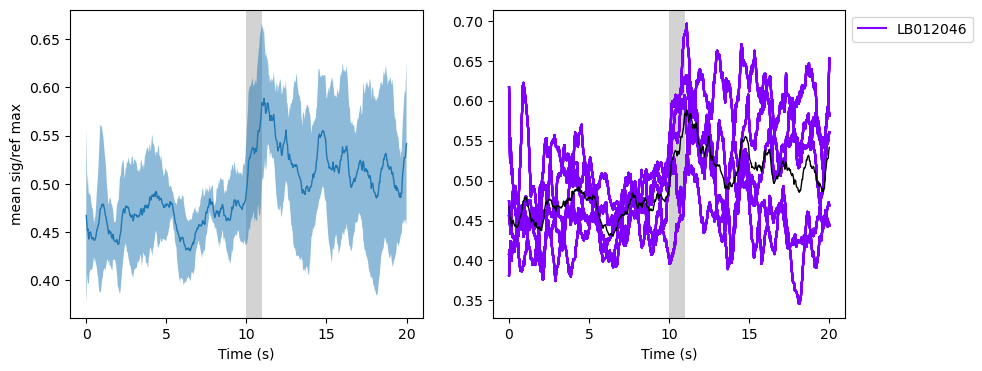

LB012047


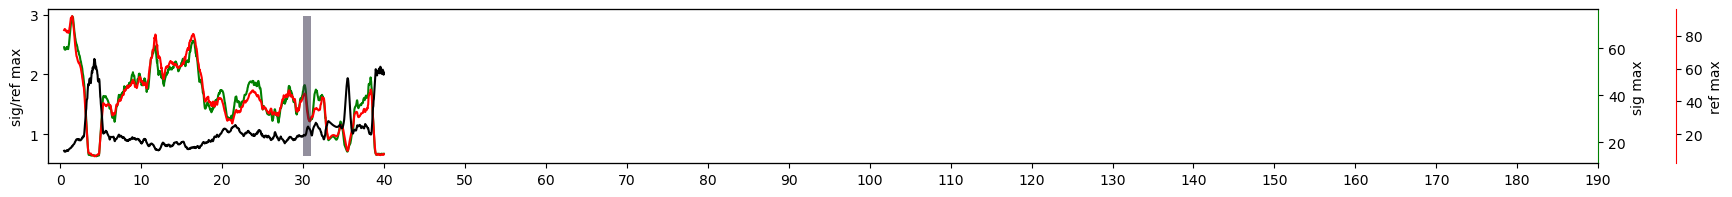

(0.7867490188335, 2.1933823218498336)


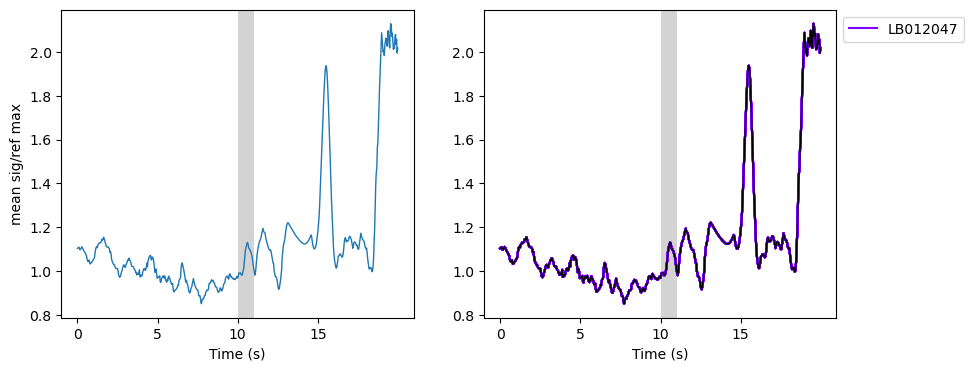

LB012048


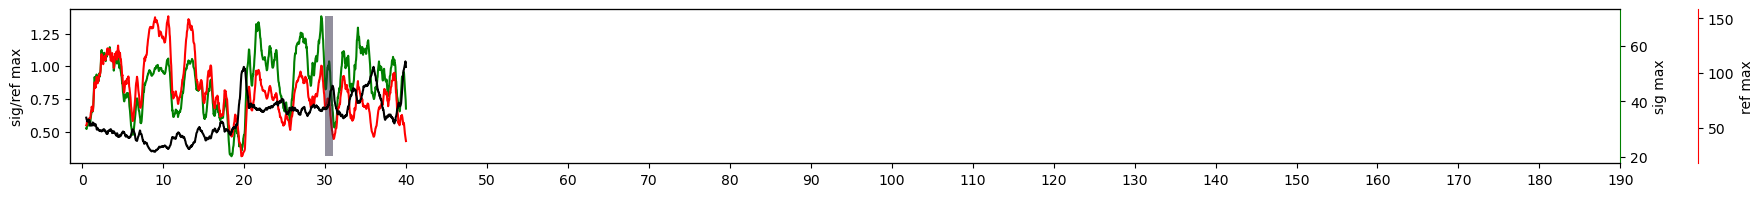

(0.5375047474635001, 1.0818875290398333)


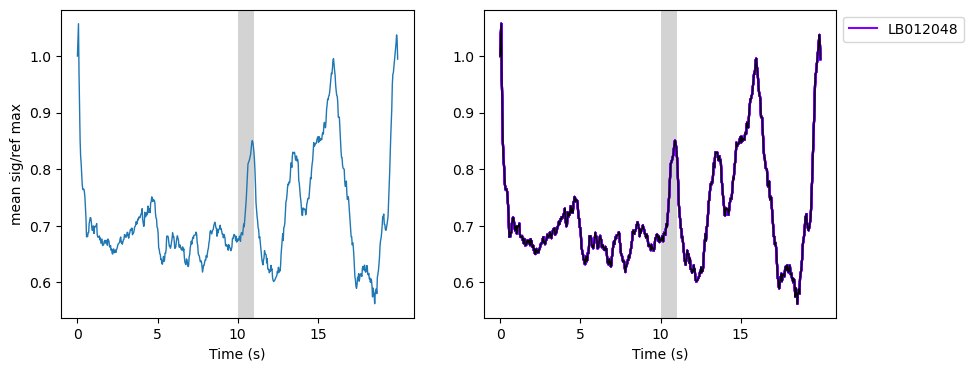

LB012049


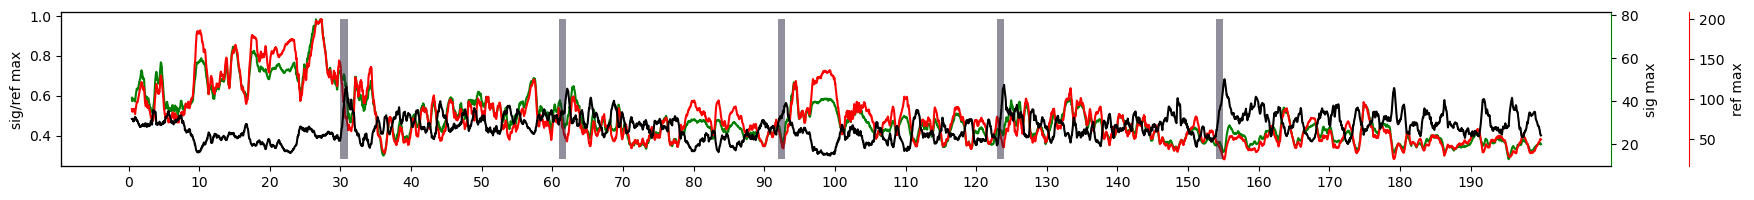

(0.30864654888093607, 0.6736401455521123)


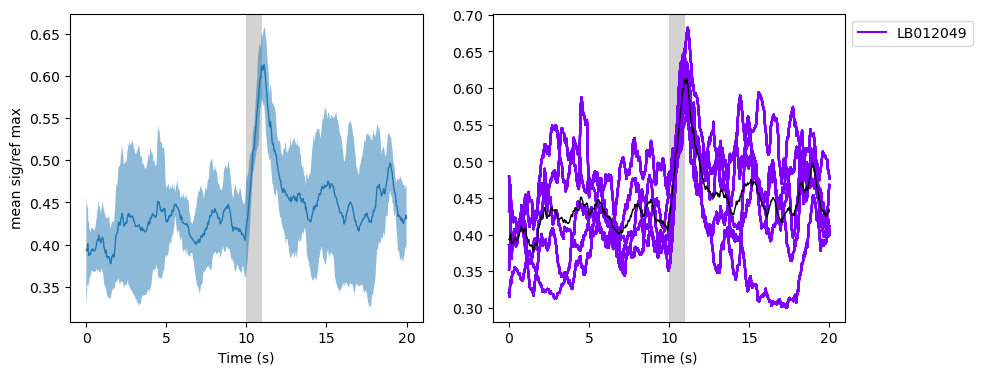

LB012051


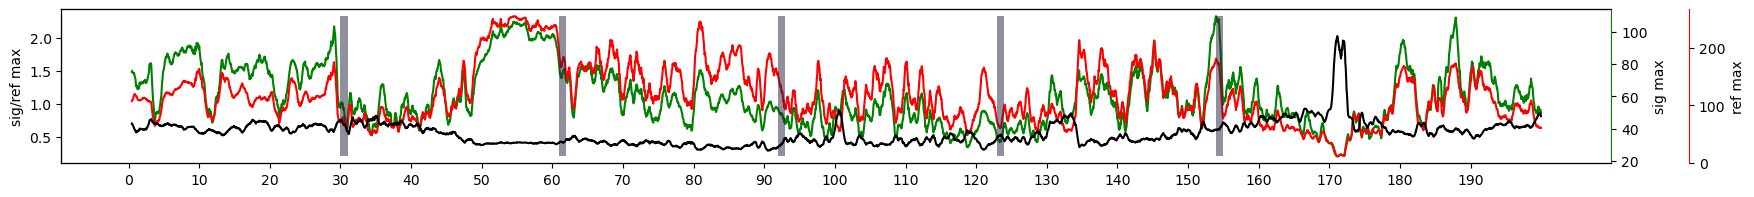

(0.2702920227145435, 0.9072432490662383)


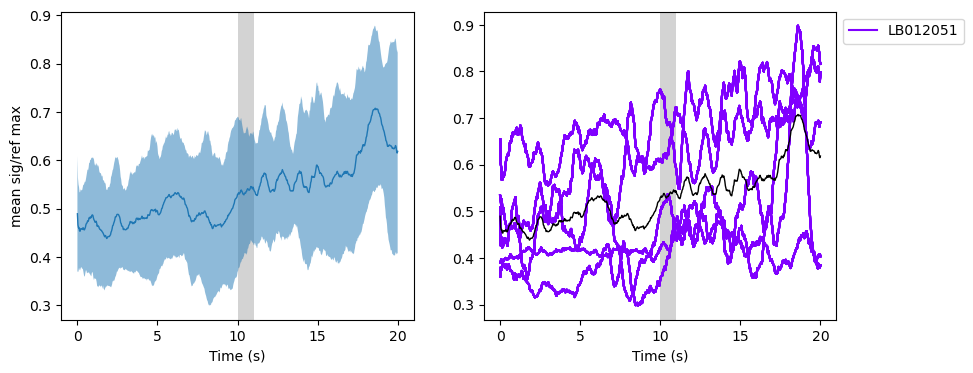

LB012052


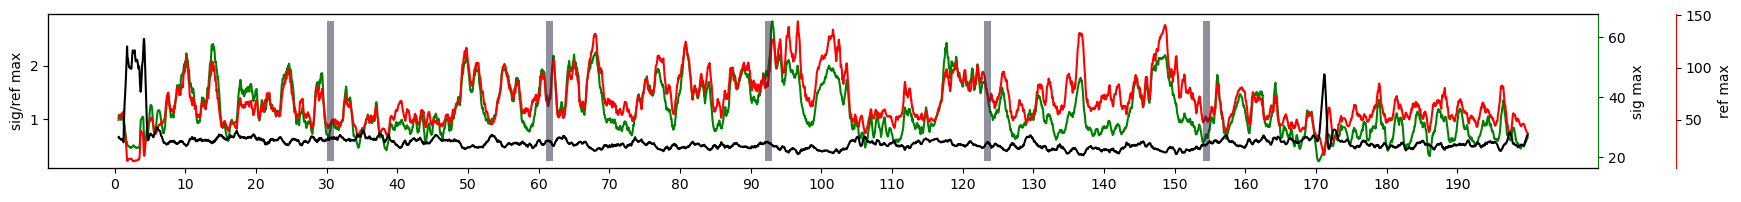

(0.34949872944854954, 0.7361132788314505)


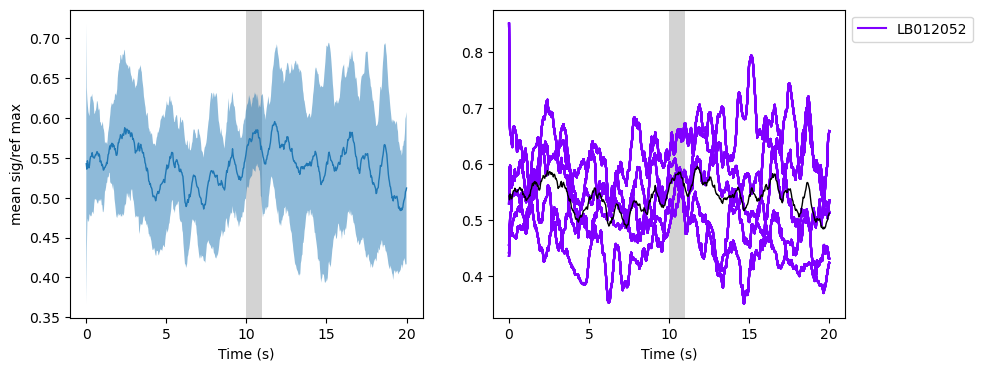

In [ ]:
# individual file analysis
for mov in multi_sig.columns.get_level_values(0).unique():
    print(mov)
    out = os.path.join(inpath, mov+'c',)
    if not os.path.exists(out):
        os.makedirs(out)
    mov_sig = multi_sig[mov]
    mov_sig = insert_level_multiindex(mov_sig, mov)
    mov_info = info.loc[mov]
    stim_before = info_get_prevstimulus(info, mov)
    plotter = CalciumPlotter(mov_sig, repeats=mov_info['stim N'], stim_before=stim_before, sig_type=sig_type, window=valid_range, trace1='sig/ref')
    trace_signal = plotter.signal_trace(mov, rolling_mean=15);
    trace_signal.savefig(os.path.join(out, f'{file_str}_trace_{sig_type}.png'), bbox_inches='tight')
    plt.show()
    plt.close()
    mean_signal = plotter.mean_signal(rolling_mean=15);
    if mean_signal is not None:
        mean_signal.savefig(os.path.join(out, f'{file_str}_meansignal_{sig_type}.png'), bbox_inches='tight')
    plt.show()
    plt.close()

### Analysis 1: all files

#### calcium

/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:174: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = aligned_df[mov_stim]


(0.9, 1.3)


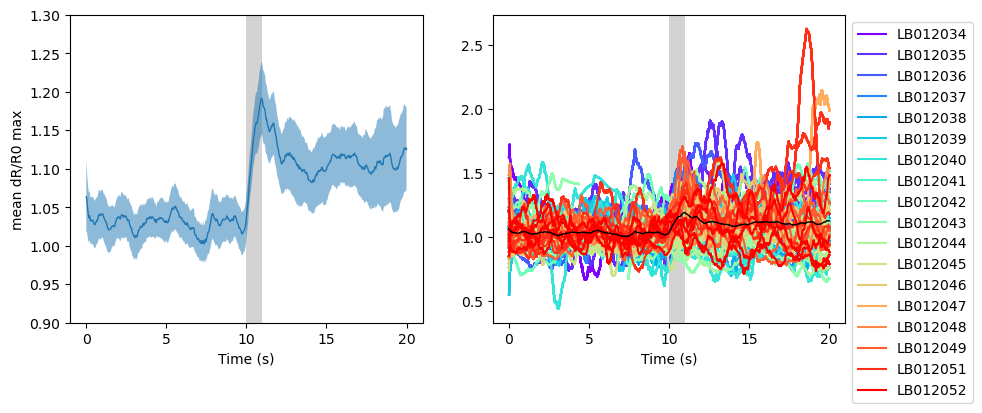

In [34]:
calciumplotter = CalciumPlotter(multi_sig, repeats=5,
                         sig_type=sig_type, trace1='sig/ref', window = valid_range)
mean_signal = calciumplotter.mean_signal(rolling_mean=15, ylim=(.9,1.3), normalize=True);
mean_signal.savefig(os.path.join(inpath, f'{file_str}_meansignal_{sig_type}_all.png'), bbox_inches='tight')
mean_signal.savefig(os.path.join(inpath, f'{file_str}_meansignal_{sig_type}_all.pdf'), bbox_inches='tight')

In [35]:
idx = pd.IndexSlice
calc_stats = stats_df(calciumplotter.df_AlignStim.loc[:,idx[:,:,'dR/R0','max']], range(300), range(300,330), 'stimulus', 'None')
calc_stats

datatype   aligned filter frames a frames b  t-statistic       p-value  \
0  [dR/R0, max]  stimulus   None    0-300  300-330    -8.174958  2.465935e-11   

   cohens d  N_animals  N_traces  
0  1.001976         15        61

#### velocity

In [36]:
multi_velo = pd.DataFrame([])
for i,mov in enumerate(multi_sig.columns.get_level_values(0).unique()):
    inp = os.path.join(mov_path,mov+'c')
    stagefile = [f for f in os.listdir(inp) if '.txt' in f][0]
    df = pd.read_csv(os.path.join(inp,stagefile), delimiter=' ', skiprows=[0,1])
    df = df[['Time', 'X', 'Y']]
    df.loc[:,'velocity'] = np.sqrt(df.X.diff(periods=5)**2 + df.Y.diff(periods = 5)**2)*fps*1000/5
    df.loc[:,'velocity_smooth'] = df.loc[:,'velocity'].rolling(2*fps, center=True, min_periods=1).mean()
    df.columns = pd.MultiIndex.from_product([[mov], df.columns])
    multi_velo = pd.concat([multi_velo,df], axis=1)

(-10, 250)


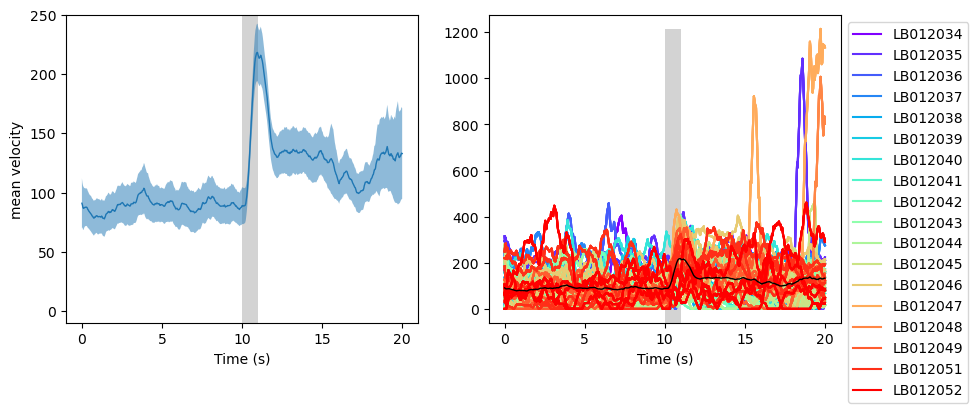

In [37]:
veloplotter = CalciumPlotter(multi_velo, repeats=5,
                         sig_type=None, trace1='velocity', window = valid_range)
mean_velo = veloplotter.mean_signal(rolling_mean=15, ylim=(-10,250));
mean_velo.savefig(os.path.join(inpath, f'{file_str}_meanvelo_{sig_type}_all.png'), bbox_inches='tight')
mean_velo.savefig(os.path.join(inpath, f'{file_str}_meanvelo_{sig_type}_all.pdf'), bbox_inches='tight')

In [38]:
idx = pd.IndexSlice
velo_stats = stats_df(veloplotter.df_AlignStim.loc[:,idx[:,:,'velocity']], range(300), range(300,330), 'stimulus', 'None')
velo_stats

datatype   aligned filter frames a frames b  t-statistic       p-value  \
0  [velocity]  stimulus   None    0-300  300-330    -9.864535  1.800352e-14   

   cohens d  N_animals  N_traces  
0  1.137263         15        65

In [39]:
N_animals = len(veloplotter.df_AlignStim.loc[:,idx[:,:,'velocity']].columns.get_level_values(0).unique())
N_traces = veloplotter.df_AlignStim.loc[:,idx[:,:,'velocity']].shape[1]
N_animals, N_traces

(18, 68)

### Intermediate: Reversals with consistent distance

In [40]:
for i, mov_stim in enumerate(multi_velo.droplevel(-1, axis=1).columns.unique()):
    print(mov_stim)
    data, smpl_idx = calculate_reversals(multi_velo[mov_stim], 1000, 2, 120, 1)
    idx = pd.IndexSlice
    multi_velo.loc[:,idx[mov_stim,'reversals']] = data['reversals']
    multi_velo.loc[:,idx[mov_stim,'angle']] = data['angle']
    
    fig = plt.figure(figsize=(5,5))
    plt.scatter(multi_velo[mov_stim]['X'],multi_velo[mov_stim]['Y'], c=multi_velo[mov_stim]['Y'].rolling(120).mean().diff())
    plt.plot(multi_velo[mov_stim]['X'][smpl_idx],multi_velo[mov_stim]['Y'][smpl_idx], 'o-', c='k') #c=np.arange(len(smpl_idx)), cmap='magma_r')
    plt.scatter(multi_velo[mov_stim]['X'][np.where(multi_velo[mov_stim]['reversals'])[0]],
                multi_velo[mov_stim]['Y'][np.where(multi_velo[mov_stim]['reversals'])[0]], 
                c='fuchsia', zorder=5)#c=np.arange(np.sum(data.reversals)), cmap='cool_r')
    plt.axis('equal');
    plt.savefig(os.path.join(inpath, mov_stim+'c','track_reversals.png'))
    plt.close()

LB012034


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012035


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012036


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012037


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012038


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012039


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012040


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012041


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012042


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012043


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012044


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012045


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012046


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012047
LB012048


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))
/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012049


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012051


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


LB012052


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:254: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arccos(np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)))


### Analysis 2: Filter for reversal

In [41]:
VeloAlignStim2 = veloplotter.create_alignment()

In [42]:
idx = pd.IndexSlice
multi_revs = VeloAlignStim2.loc[:,idx[:,:,'reversals']].copy()
withrevs = (multi_revs[300:390] == 1).max().droplevel(-1)
withrevs_idx = withrevs[withrevs].index

(-10, 300)


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:174: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = aligned_df[mov_stim]


(0.85, 1.4)


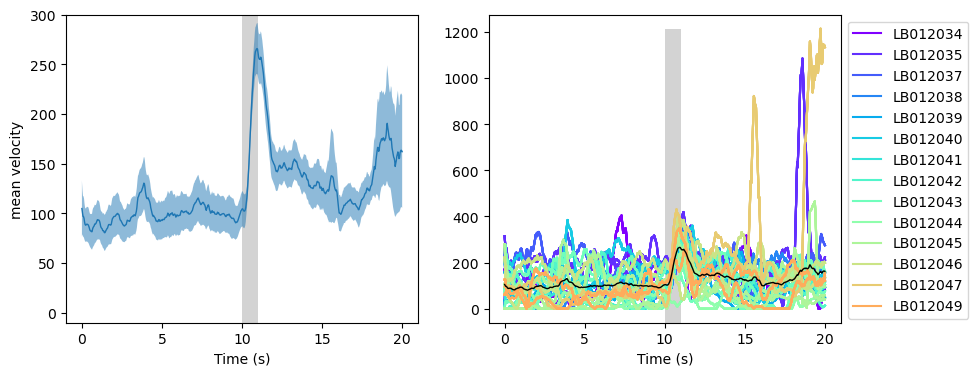

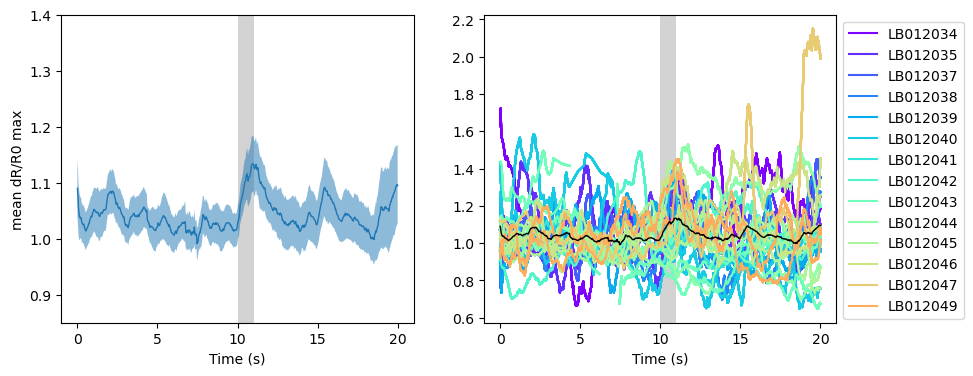

In [43]:
#veloplotter.df_AlignStim.T.loc[(slice('LB012033', 1830),),:]
withrevs_velo_mask = veloplotter.df_AlignStim.columns.isin(list(withrevs_idx))
withrevs_calc_mask = calciumplotter.df_AlignStim.columns.isin(list(withrevs_idx))

# Use the mask to filter the DataFrame
withrevs_velo = veloplotter.df_AlignStim.T[withrevs_velo_mask].T
withrevs_calc = calciumplotter.df_AlignStim.T[withrevs_calc_mask].T

veloplotter.trace1 = 'velocity'
withrevs_velo_plot = veloplotter.mean_signal(rolling_mean=15, aligned_df=withrevs_velo, ylim=(-10,300));
withrevs_calc_plot = calciumplotter.mean_signal(rolling_mean=15, aligned_df=withrevs_calc,  ylim=(0.85, 1.4));

withrevs_velo_plot.savefig(os.path.join(inpath, f'{file_str}_meanvelo_{sig_type}_withrevs.png'), bbox_inches='tight')
withrevs_calc_plot.savefig(os.path.join(inpath, f'{file_str}_meansignal_{sig_type}_withrevs.png'), bbox_inches='tight')

In [44]:
velo_stats = stats_df(withrevs_velo.loc[:,idx[:,:,'velocity']], range(300), range(300,330), 'stimulus', 'Movement Vector >= 120 deg', velo_stats)
calc_stats = stats_df(withrevs_calc.loc[:,idx[:,:,'dR/R0','max']], range(300), range(300,330), 'stimulus', 'Movement Vector >= 120 deg', calc_stats)
calc_stats

datatype   aligned                      filter frames a frames b  \
0  [dR/R0, max]  stimulus                        None    0-300  300-330   
1  [dR/R0, max]  stimulus  Movement Vector >= 120 deg    0-300  300-330   

   t-statistic       p-value  cohens d  N_animals  N_traces  
0    -8.174958  2.465935e-11  1.001976         15        61  
1    -4.394401  3.116627e-04  0.924891         12        20

In [45]:
velo_stats

datatype   aligned                      filter frames a frames b  \
0  [velocity]  stimulus                        None    0-300  300-330   
1  [velocity]  stimulus  Movement Vector >= 120 deg    0-300  300-330   

   t-statistic       p-value  cohens d  N_animals  N_traces  
0    -9.864535  1.800352e-14  1.137263         15        65  
1    -9.438923  3.415333e-09  1.717274         12        23

### Analysis 3: Filter without reversals

In [46]:
norevs = ~(multi_revs[300:390] == 1).max().droplevel(-1)
norevs_idx = withrevs[norevs].index

(-10, 300)


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:174: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = aligned_df[mov_stim]


(0.85, 1.4)


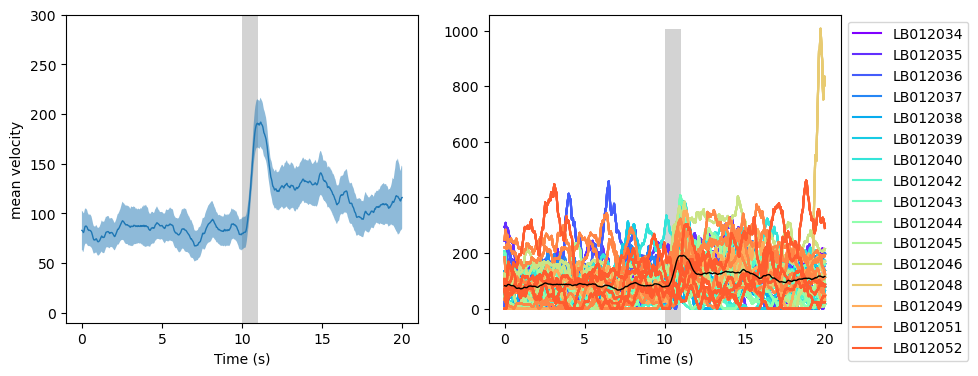

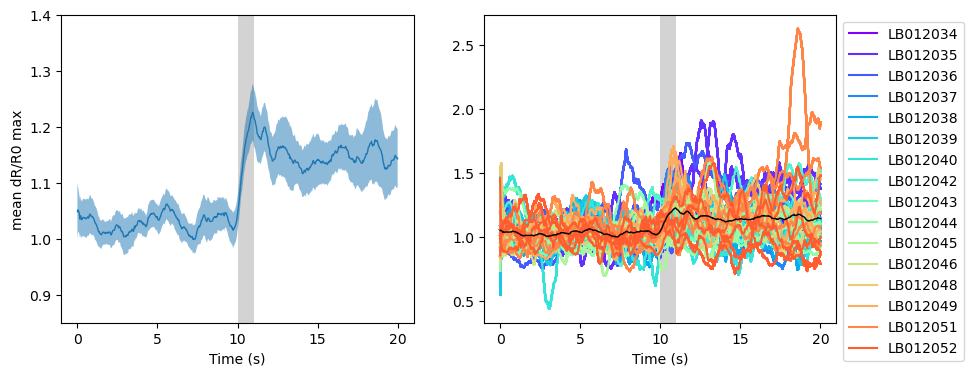

In [47]:
#veloplotter.df_AlignStim.T.loc[(slice('LB012033', 1830),),:]
norevs_velo_mask = veloplotter.df_AlignStim.columns.isin(list(norevs_idx))
norevs_calc_mask = calciumplotter.df_AlignStim.columns.isin(list(norevs_idx))

# Use the mask to filter the DataFrame
norevs_velo = veloplotter.df_AlignStim.T[norevs_velo_mask].T
norevs_calc = calciumplotter.df_AlignStim.T[norevs_calc_mask].T

veloplotter.trace1 = 'velocity'
norevs_velo_plot = veloplotter.mean_signal(rolling_mean=15, aligned_df=norevs_velo, ylim=(-10,300));
norevs_calc_plot = calciumplotter.mean_signal(rolling_mean=15, aligned_df=norevs_calc,  ylim=(0.85, 1.4));

norevs_velo_plot.savefig(os.path.join(inpath, f'{file_str}_meanvelo_{sig_type}_norevs.png'), bbox_inches='tight')
norevs_calc_plot.savefig(os.path.join(inpath, f'{file_str}_meansignal_{sig_type}_norevs.png'), bbox_inches='tight')

In [48]:
velo_stats = stats_df(norevs_velo.loc[:,idx[:,:,'velocity']], range(300), range(300,330), 'stimulus', 'Movement Vector < 120 deg', velo_stats)
calc_stats = stats_df(norevs_calc.loc[:,idx[:,:,'dR/R0','max']], range(300), range(300,330), 'stimulus', 'Movement Vector < 120 deg', calc_stats)
calc_stats

datatype   aligned                      filter frames a frames b  \
0  [dR/R0, max]  stimulus                        None    0-300  300-330   
1  [dR/R0, max]  stimulus  Movement Vector >= 120 deg    0-300  300-330   
2  [dR/R0, max]  stimulus   Movement Vector < 120 deg    0-300  300-330   

   t-statistic       p-value  cohens d  N_animals  N_traces  
0    -8.174958  2.465935e-11  1.001976         15        61  
1    -4.394401  3.116627e-04  0.924891         12        20  
2    -6.878288  2.771571e-08  1.037367         15        41

In [49]:
velo_stats

datatype   aligned                      filter frames a frames b  \
0  [velocity]  stimulus                        None    0-300  300-330   
1  [velocity]  stimulus  Movement Vector >= 120 deg    0-300  300-330   
2  [velocity]  stimulus   Movement Vector < 120 deg    0-300  300-330   

   t-statistic       p-value  cohens d  N_animals  N_traces  
0    -9.864535  1.800352e-14  1.137263         15        65  
1    -9.438923  3.415333e-09  1.717274         12        23  
2    -6.332964  1.453647e-07  0.986017         15        42

(-0.02455688710374871, 0.21974516476405564)
(-0.02060138436045035, 0.10551484171687589)


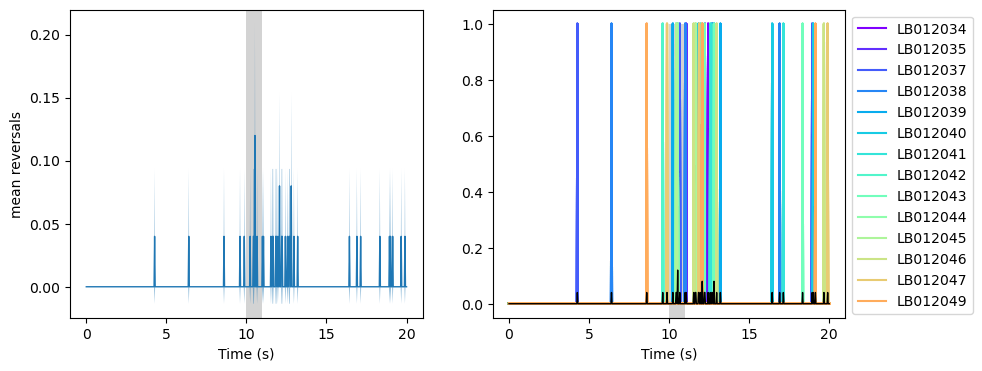

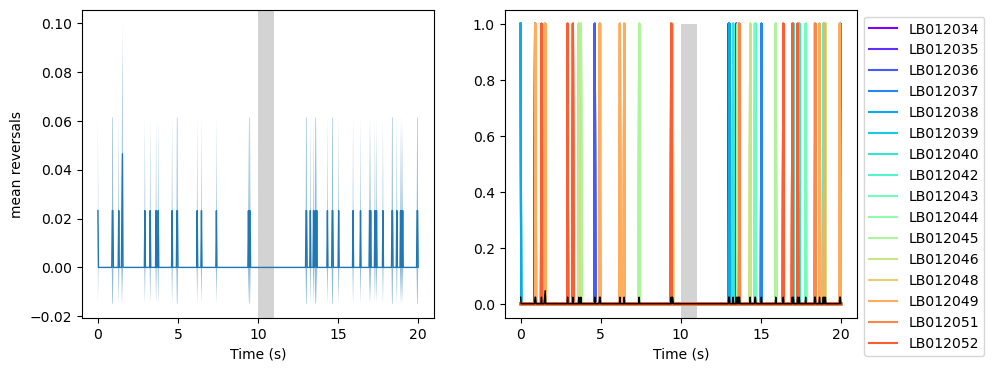

In [50]:
veloplotter.trace1 = 'reversals'
withrevs_rev_plot= veloplotter.mean_signal(rolling_mean=1, aligned_df=withrevs_velo);
norevs_rev_plot = veloplotter.mean_signal(rolling_mean=1, aligned_df=norevs_velo);

withrevs_rev_plot.savefig(os.path.join(inpath, f'{file_str}_reversals_{sig_type}_withrevs.png'), bbox_inches='tight')
norevs_rev_plot.savefig(os.path.join(inpath, f'{file_str}_reversals_{sig_type}_norevs.png'), bbox_inches='tight')

In [51]:
def extract_peak_height(df, peak_range, baseline_range, find_peaks_param = {'distance':10, 'prominence':.05}):
    df_out = pd.DataFrame([])
    for col in df:
        peaks_max = df[col].loc[peak_range].max()
        prestim_mean = df[col].loc[baseline_range].mean()
        
        peakheight = peaks_max - prestim_mean
        
        midx = pd.MultiIndex.from_tuples([col])
        df_out = pd.concat([df_out, pd.DataFrame([peakheight], columns=midx, index=['peak_height'])], axis=1)
    
    return df_out

In [52]:
def swarm_from_bins(y, bin_step=30, x_base=0):
    sort_idx = np.argsort(y)
    y = y.iloc[sort_idx]
    get_org_idx = np.argsort(sort_idx)
    
    hist, bins = np.histogram(y, bin_step)
    bin_size = (np.max(y)-np.min(y))/bin_step
    
    x = np.zeros_like(y)
    for i in range(len(bins)):
        y_in_bin = np.bitwise_and(y >= bins[i], y < bins[i+1])
        y_i = y[y_in_bin]
        if len(y_i) > 1:
            cumsum_steps = np.cumsum(np.repeat(bin_size, len(y_i)))
            x_i = cumsum_steps-(cumsum_steps[-1]/2)-bin_size/2
            x_i = x_i[np.argsort(abs(x_i))]
            x[y_in_bin] = x_i
            break
    x = x[get_org_idx]+x_base
    y = y.iloc[get_org_idx]
    return x

In [53]:
calcium_peaks = extract_peak_height(calciumplotter.df_AlignStim.loc[:,idx[:,:,'dR/R0', 'max']].rolling(15, min_periods=1).mean(), range(300,330), range(300)).T
velo_peaks =  extract_peak_height(veloplotter.df_AlignStim.loc[:,idx[:,:,'velocity']].rolling(15, min_periods=1).mean(), range(300,330), range(300)).T.droplevel(-1)

calcium_peaks.loc[:, 'velo_peakheight'] = velo_peaks['peak_height']
calcium_peaks.loc[:,'reversal'] = withrevs.astype(int)
calcium_peaks.loc[:,'max_angle'] = np.max(VeloAlignStim2.loc[300:360,idx[:,:,'angle']], axis=0).droplevel(-1).fillna(0)
calcium_peaks.loc[:,'mean_prestim_angle'] = np.max(VeloAlignStim2.loc[:300,idx[:,:,'angle']], axis=0).droplevel(-1).fillna(0)
calcium_peaks.loc[:,'mean_velocity'] = np.mean(VeloAlignStim2.loc[300:360,idx[:,:,'velocity']], axis=0).droplevel(-1)
calcium_peaks.loc[:,'mean_prestim_velocity'] = np.mean(VeloAlignStim2.loc[:300,idx[:,:,'velocity']], axis=0).droplevel(-1)
calcium_peaks.loc[:,'sig_mean_poststim'] = np.nanmean(calciumplotter.df_AlignStim.loc[330:,idx[:,:,'dR/R0', 'max']], axis=0)

calcium_peaks = calcium_peaks.reset_index(level=[0,1], ).rename(columns={'level_0':'wormID','level_1':'t_stim'})

In [54]:
calcium_peaks

wormID  t_stim  peak_height  velo_peakheight  reversal  \
dR/R0 max  LB012034     900     0.166004       157.694597         1   
      max  LB012034    1830     0.460843       182.163888         0   
      max  LB012035     900     0.334659       211.697172         0   
      max  LB012035    1830     0.451047       157.491002         0   
      max  LB012035    2760     0.179876       219.431490         1   
...             ...     ...          ...              ...       ...   
      max  LB012052     900     0.112635        97.209363         0   
      max  LB012052    1830     0.112082        -0.853089         0   
      max  LB012052    2760     0.158266        42.411370         0   
      max  LB012052    3690     0.024144        22.749829         0   
      max  LB012052    4620     0.281974        85.284365         0   

           max_angle  mean_prestim_angle  mean_velocity  \
dR/R0 max   0.000000          110.643976     149.804230   
      max  85.324355            0.000000     160.931246   
      max  60.152037            0.000000     195.411154   
      max  13.680241           63.182578     188.814298   
      max   7.776132           47.806092     266.767817   
...              ...                 ...            ...   
      max  10.968684           44.689846     147.079071   
      max   0.000000          160.571036      89.412784   
      max   0.000000          133.613762      44.168088   
      max   0.000000          146.904855     114.534049   
      max  20.579179           41.736562     172.059119   

           mean_prestim_velocity  sig_mean_poststim  
dR/R0 max             112.139045           1.255037  
      max              42.904341           1.166815  
      max              32.407041           1.403765  
      max              97.644334           1.445210  
      max             168.039978           1.123968  
...                          ...                ...  
      max             130.555193           1.098918  
      max              95.387977           1.004038  
      max              94.387265           0.887728  
      max             146.513091           0.931375  
      max              47.325835           1.315960  

[68 rows x 10 columns]

In [55]:
calcium_peaks.to_csv(os.path.join(inpath, f'{file_str}_peak_height.csv'))

/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:174: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = aligned_df[mov_stim]


(0.9, 1.3)


/gpfs/soma_fs/home/boeger/code/calcium_TRN/calcium_analysis.py:174: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = aligned_df[mov_stim]


(0.9, 1.3)


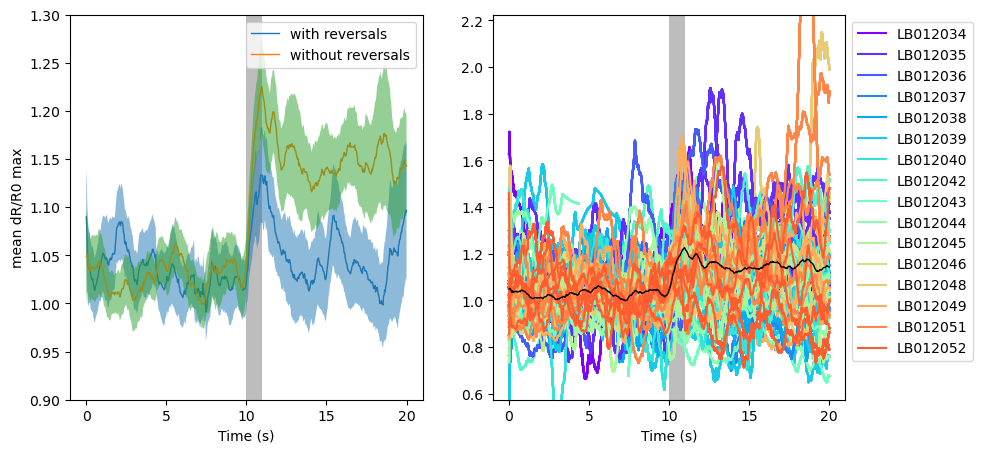

In [56]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
calciumplotter.mean_signal(rolling_mean=15, aligned_df=withrevs_calc, ylim=(.9,1.3), axs=axs, meanlabel='with reversals')
calciumplotter.mean_signal(rolling_mean=15, aligned_df=norevs_calc, ylim=(.9,1.3), axs=axs, meanlabel='without reversals')
axs[0].legend()
plt.savefig(os.path.join(inpath, f'{file_str}_overlay_filterreversal.pdf'), bbox_inches='tight')